In [1]:
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

In [2]:
#!pip install scikit-learn

In [3]:
device = 'cpu'
momentum = 0.9
num_epochs = 10


num_classes = 5
val_size = 0.2
test_size = 0.2

batch_size = 150
learn_rate = 0.001
data_path = '../data/my-data/my-classification-dataset/'

In [4]:

train_transform = transforms.Compose(
    [
        #The image will be flipped horizontally with a 50% probability. Can increase the model’s robustness to direction
        transforms.RandomHorizontalFlip(p=0.5),
        # Flip the image vertically with 50% probability to increase the model's robustness to up and down flips
        transforms.RandomVerticalFlip(p=0.5),
        # Perform a random rotation between -90 and 90 degrees
        transforms.RandomRotation(degrees=(-90,90)),
        #A random affine transformation will be performed on the image, including a random rotation between -30 and 30 degrees, a random translation of 25% of the width and height, and a random scaling between 0.85 and 1.15
        transforms.RandomAffine(degrees=(-30,30),translate=(0.25,0.25),scale=(0.85,1.15)),
        #Randomly change the brightness, contrast, saturation and hue of the picture
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        #Crop the image to 64x64 size and use anti-aliasing. This ensures uniform input
        transforms.RandomResizedCrop(size=(64, 64), antialias=True),
        #
        transforms.ToTensor(),
        #Further normalize so that its mean and standard deviation are close to the set values
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:

val_transform = transforms.Compose(
    [   #Resize (scale) the image to 64x64 and use anti-aliasing
        torchvision.transforms.Resize(64, antialias=True),
        #Center crop the image, keeping the size at 64x64
        torchvision.transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [6]:
#这部分的代码不需要修改

# # Instatiate train and validation dataset with seperate transforms
# train_dataset = ImageFolder(data_path, transform=train_transform)
# val_dataset = ImageFolder(data_path, transform=val_transform)
# 
# # Get length of dataset and indicies
# num_train = len(train_dataset)
# indices = list(range(num_train))
# 
# # Get train / val split for data points
# train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)
# 
# # Override dataset classes to only be samples for each split
# train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
# val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
# 
# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

'''
First, all data is divided into a training set and a temporary set, where the temporary set contains validation and test data, and then the validation set and test set are divided again in the temporary set. You will get three data loaders: training set, validation set and test set.
'''
# Instantiate dataset with transform
dataset = ImageFolder(data_path, transform=train_transform)

# Get length of dataset and indices
num_samples = len(dataset)
indices = list(range(num_samples))

# First split for train and temporary split. Test size here is combined validation and test size
train_indices, temp_indices = train_test_split(indices, test_size=val_size + test_size, random_state=42)

# Second split for validation and test from the temporary split
val_indices, test_indices = train_test_split(temp_indices, test_size=test_size/(val_size + test_size), random_state=42)

# Override dataset samples to only be samples for each split
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

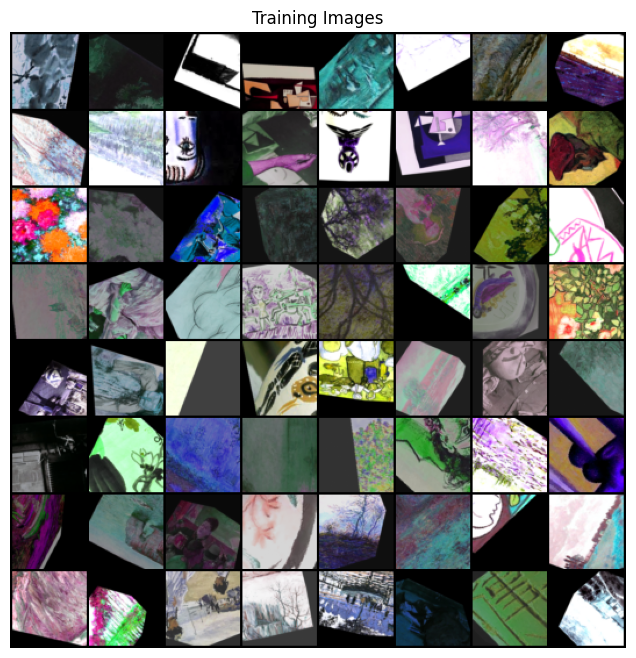

In [7]:

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

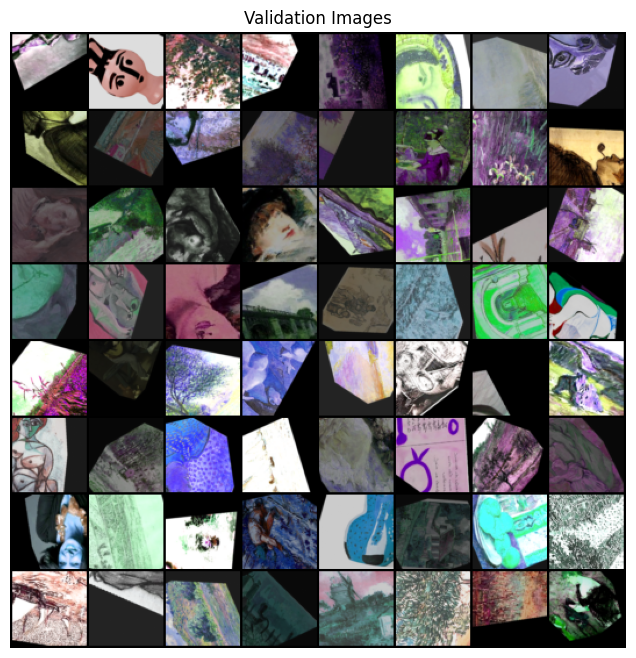

In [8]:


# Plot some training images
real_batch = next(iter(val_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Validation Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

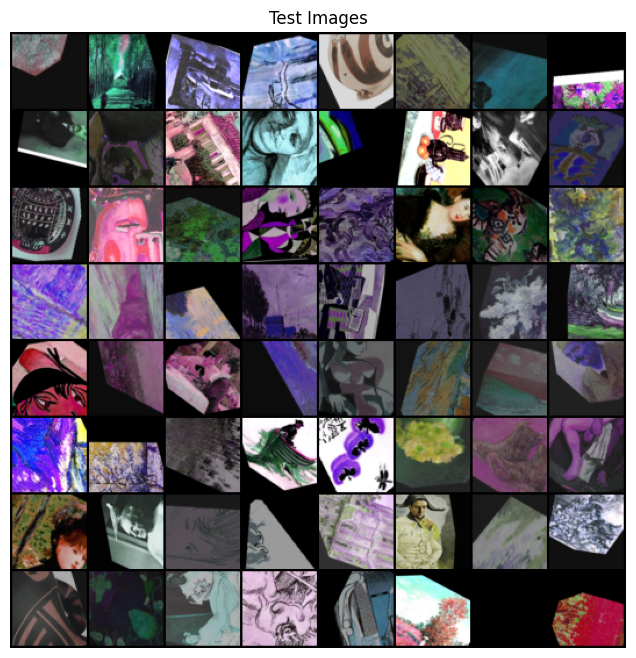

In [9]:
# Plot some test images
real_batch = next(iter(test_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# class ClassificationNetwork(nn.Module):
#     #
#     def __init__(self):
#         #
#         super().__init__()
#         #
#         self.conv1 = nn.Conv2d(3, 64, 5)
#         #
#         self.conv2 = nn.Conv2d(64, 128, 5)
#         #
#         self.conv3 = nn.Conv2d(128, 128, 5)
#         #
#         self.pool = nn.MaxPool2d(2, 2)
#         #
#         self.fc1 = nn.Linear(2048, 256)
#         #
#         self.fc2 = nn.Linear(256, num_classes)
# 
#     #
#     def forward(self, x):
#         #
#         x = F.relu(self.conv1(x))
#         #
#         x = self.pool(x)
#         #
#         x = F.relu(self.conv2(x))
#         #
#         x = self.pool(x)
#         #
#         x = F.relu(self.conv3(x))
#         #
#         x = self.pool(x)
#         #
#         x = torch.flatten(x, 1)
#         #
#         x = F.relu(self.fc1(x))
#         #
#         x = self.fc2(x)
#         #
#         return x
''':
I reduced the number of filters in the first two convolutional layers, which reduces the model size and computational requirements. At the same time, by adding padding in the convolution operation, it can be ensured that the size of the feature map is maintained after the convolution operation. A Dropout layer is added to prevent model overfitting. The number of neurons in the first fully connected layer is returned to 512 to reduce model complexity and increase training speed.
'''
class ClassificationNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 8 * 8)

        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x   


In [11]:


model = ClassificationNetwork()
model.to(device)

# Cross entropy loss for training classification
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent loss
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

In [14]:


train_losses = []
val_losses = []

best_loss = 100000
for epoch in range(num_epochs): 
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')
    
    # if validation score is lowest so far, save the model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_from_scratch.pt')

Epoch 1, train loss: 1.558, val loss: 1.493
Epoch 2, train loss: 1.470, val loss: 1.457
Epoch 3, train loss: 1.457, val loss: 1.449
Epoch 4, train loss: 1.452, val loss: 1.447
Epoch 5, train loss: 1.448, val loss: 1.443
Epoch 6, train loss: 1.443, val loss: 1.438
Epoch 7, train loss: 1.441, val loss: 1.435
Epoch 8, train loss: 1.437, val loss: 1.427
Epoch 9, train loss: 1.435, val loss: 1.430
Epoch 10, train loss: 1.437, val loss: 1.427


In [15]:
from sklearn.metrics import confusion_matrix, classification_report



# Loading the best model
model.load_state_dict(torch.load('best_model_from_scratch.pt'))

# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track predictions and targets
all_preds = []
all_targets = []

# Testing loop
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions from the maximum value of output
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

        # Append batch predictions and targets
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Calculating accuracy
accuracy = 100 * correct / total

# Normalise test loss to dataset size
test_loss = test_loss / len(test_loader)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(all_targets, all_preds)
print('Confusion Matrix:')
print(confusion_mtx)

# Calculate classification report
classification_rep = classification_report(all_targets, all_preds)
print('\nClassification Report:')
print(classification_rep)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {accuracy:.2f}%')

Confusion Matrix:
[[ 33   0 153 518   0]
 [ 14   0  41  91   0]
 [ 12   0 223 577   0]
 [ 13   0 149 731   0]
 [  7   0  47 241   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.05      0.08       704
           1       0.00      0.00      0.00       146
           2       0.36      0.27      0.31       812
           3       0.34      0.82      0.48       893
           4       0.00      0.00      0.00       295

    accuracy                           0.35      2850
   macro avg       0.22      0.23      0.18      2850
weighted avg       0.31      0.35      0.26      2850

Test Loss: 1.439, Test Accuracy: 34.63%


c:\Users\ALIENWARE\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ALIENWARE\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ALIENWARE\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


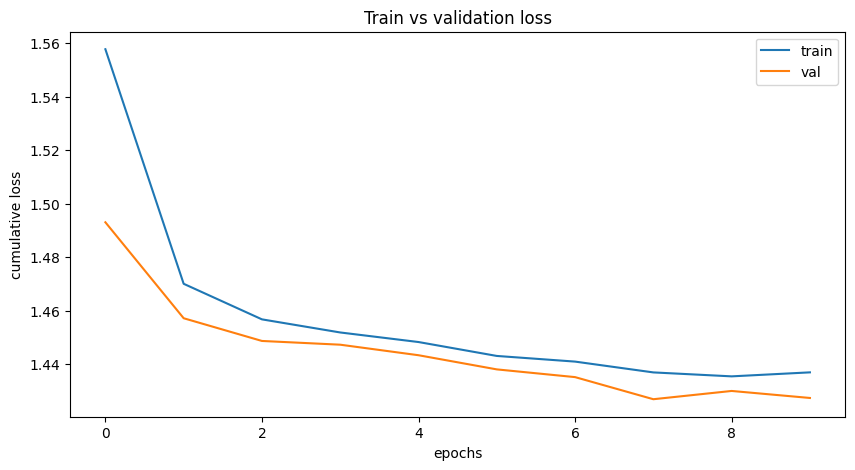

In [16]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()